In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/RedeNeural"
!pwd

/content/drive/MyDrive/RedeNeural
/content/drive/MyDrive/RedeNeural


not _datagen_2 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx False
DATA GENERATOR: Loading data from task 1.
DATA GENERATOR: 1.csv was loaded.
DATA GENERATOR: 2.csv was loaded.
DATA GENERATOR: 3.csv was loaded.
DATA GENERATOR: 4.csv was loaded.
DATA GENERATOR: 5.csv was loaded.
DATA GENERATOR: 6.csv was loaded.
DATA GENERATOR: 7.csv was loaded.
DATA GENERATOR: 8.csv was loaded.
DATA GENERATOR: 9.csv was loaded.
DATA GENERATOR: 10.csv was loaded.
DATA GENERATOR: 11.csv was loaded.
DATA GENERATOR: 12.csv was loaded.
DATA GENERATOR: 13.csv was loaded.
DATA GENERATOR: 14.csv was loaded.
DATA GENERATOR: 15.csv was loaded.
DATA GENERATOR: 16.csv was loaded.
DATA GENERATOR: 17.csv was loaded.
DATA GENERATOR: 18.csv was loaded.
DATA GENERATOR: 19.csv was loaded.
DATA GENERATOR: 20.csv was loaded.
DATA GENERATOR: 21.csv was loaded.
DATA GENERATOR: 22.csv was loaded.
DATA GENERATOR: 23.csv was loaded.
DATA GENERATOR: 24.csv was loaded.
DATA GENERATOR: 25.csv was loaded.
DATA GENERATOR: 26.csv was loaded.
DAT

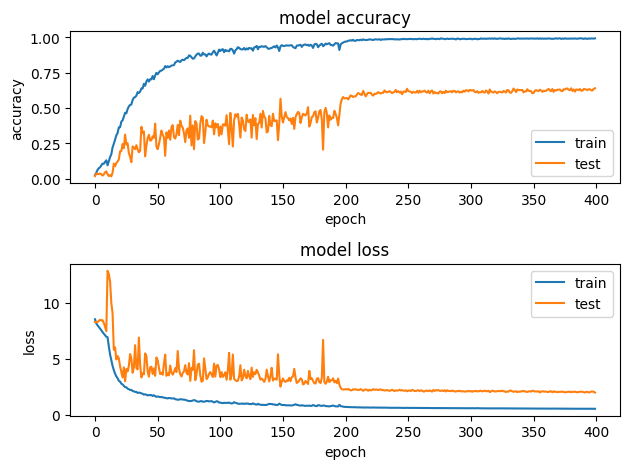

Maximum Loss : 8.5248
Minimum Loss : 0.5169
Loss difference : 8.0079

model was saved to model_weights.h5.

not _noimode_2 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx True

Evaluating on training set...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


loss=0.4662, accuracy: 100.0000%

Evaluating on validation set...
loss=2.0398, accuracy: 62.6667%

Evaluating on testing set...
loss =11.8259, accuracy: 7.1637%

Evaluating on testing set time in miliseconds: 369.03905868530273
Evaluating on testing set time in seconds: 0.36903905868530273
Evaluating on testing set time in minutes: 0.006150650978088379

not _novmode_2 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx True
Model: "Regularized_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv1D)              (None, 300, 256)          1536      
                                                                 
 Norm1 (BatchNormalization)  (None, 300, 256)          1024      
                                                                 
 Pool1 (MaxPooling1D)        (None, 150, 256)          0         
                                                                 
 Conv2 (Conv1D)              (None, 15

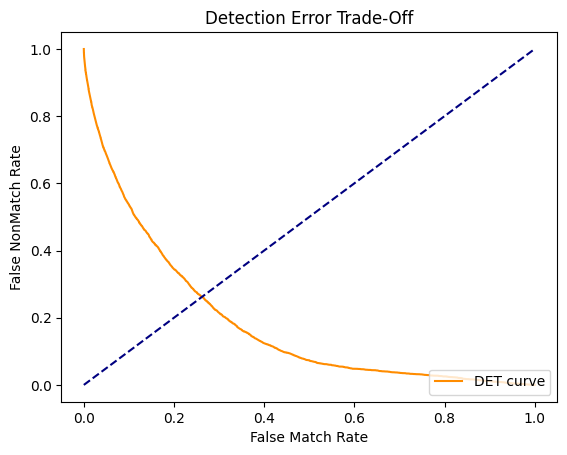

EER: 26.18723664565248 %
Decidability: 1.3031552407206481


In [ ]:
import models
import data_manipulation
import preprocessing
import utils
import loader

import argparse
import sys
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from numpy import savetxt, loadtxt

from tensorflow.keras.optimizers import Adam ##
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint ##

# Seeds
random.seed(1051)
np.random.seed(1051)
tf.random.set_seed(1051)

# Hyperparameters
batch_size = 100                # Batch Size
training_epochs = 400           # Total number of training epochs
initial_learning_rate =  0.01   # 0.01    # Initial learning rate

num_classes = 56
num_channels = 1

# # Parameters used in functions.load_data()
folder_path = '/content/drive/MyDrive/RedeNeural/Dataset_CSV_V_2/'
processed_data_path = '/content/drive/MyDrive/RedeNeural/'




# Parameters used in functions.filter_data()
# band_pass_1 = [1, 50]           # First filter option, 01~50Hz
# band_pass_2 = [10, 30]          # Second filter option,10~30Hz
# band_pass_3 = [30, 50]          # Third filter option, 30~50Hz
band_pass_4 = [0.01, 29]        # Four filter option,  00~30Hz
sample_frequency = 60 #160      # Frequency of the sampling
filter_order = 12               # Order of the filter
filter_type = 'filtfilt'        # Type of the filter used: 'sosfilt' or 'filtfilt'

# Parameters used in functions.normalize_data()
normalize_type = 'each_channel' # Type of the normalization that will be applied: 'each_channel' or 'all_channels'

# Parameters used in functions.crop_data()
window_size = 300 #1920         # Sliding window size, used when composing the dataset
offset      = 30  #35           # Sliding window offset (deslocation), used when composing the dataset
split_ratio = 0.9               # 90% for training | 20% for validation


# VARIAVEIS
train_tasks = [1]
test_tasks = [2]
_nofit   = False
_nodeep  = False
_datagen = True
_noimode = False  # -> model in Identification Mode
_novmode = False  # -> model in Verification Mode


for task in train_tasks:
    if(task <= 0 or task >= 15):
        print('ERROR: All training/validation and testing tasks need to be higher than 0 and lower than 15.\n')
        sys.exit()

for task in test_tasks:
    if(task <= 0 or task >= 15):
        print('ERROR: All training/validation and testing tasks need to be higher than 0 and lower than 15.\n')
        sys.exit()

# Defining the optimizer and the learning rate scheduler
opt = SGD(learning_rate = initial_learning_rate, momentum = 0.9)
lr_scheduler = LearningRateScheduler(models.scheduler, verbose = 0)
saver = models.SaveAtEpochEnd(5, 'model_weights')
model = None


# Not using Data Generators
if(not _datagen):
    print('not _datagen xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', not _datagen)
    # Loading the raw data
    train_content, test_content = loader.load_data(folder_path, train_tasks, test_tasks, 'csv', num_classes, 1)


    # Filtering the raw data
    train_content = preprocessing.filter_data(train_content, band_pass_4, sample_frequency, filter_order, filter_type, 1)
    test_content = preprocessing.filter_data(test_content, band_pass_4, sample_frequency, filter_order, filter_type, 1)

    # Normalize the filtered data
    train_content = preprocessing.normalize_data(train_content, 'sun', 1)
    test_content = preprocessing.normalize_data(test_content, 'sun', 1)

    # Getting the training, validation and testing data
    x_train, y_train, x_val, y_val = data_manipulation.crop_data(train_content, train_tasks, num_classes,
                                                        window_size, offset, split_ratio)

    print('x_train.shape, y_train.shape, x_val.shape, y_val.shape',x_train.shape, y_train.shape, x_val.shape, y_val.shape)

    x_test, y_test = data_manipulation.crop_data(test_content, test_tasks, num_classes, window_size,
                                        window_size)

    print('x_test.shape, y_test.shape',x_test.shape, y_test.shape)

    # Training the model
    if(not _nofit):
        print('not _nofit xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', not _nofit)
        # Creating the model
        model = models.create_cnn_based_on(window_size, num_channels, num_classes)
        model.summary()

        # Compiling, defining the LearningRateScheduler and training the model
        model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

        fit_begin = time.time()

        results = model.fit(x_train,
                            y_train,
                            batch_size = batch_size,
                            epochs = training_epochs,
                            callbacks = [lr_scheduler],
                            validation_data = (x_val, y_val)
                            )

        fit_end = time.time()
        print(f'Training time in seconds: {fit_end - fit_begin}')
        print(f'Training time in minutes: {(fit_end - fit_begin)/60.0}')
        print(f'Training time in hours: {(fit_end - fit_begin)/3600.0}\n')

        # Summarize history for accuracy
        plt.subplot(211)
        plt.plot(results.history['accuracy'])
        plt.plot(results.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'])

        # Summarize history for loss
        plt.subplot(212)
        plt.plot(results.history['loss'])
        plt.plot(results.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'])
        plt.tight_layout()
        plt.savefig(r'accuracy-loss.png', format='png')
        plt.show()

        max_loss = np.max(results.history['loss'])
        min_loss = np.min(results.history['loss'])
        print("Maximum Loss : {:.4f}".format(max_loss))
        print("Minimum Loss : {:.4f}".format(min_loss))
        print("Loss difference : {:.4f}\n".format((max_loss - min_loss)))

        # Saving model weights
        model.save('model_weights.h5')
        print('model was saved to model_weights.h5.\n')

    # Running the model in Identification Mode
    if(not _noimode):
        print('not _noimode xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', not _noimode)
        # Evaluate the model to see the accuracy
        if(model is None):
            model = models.create_cnn_based_on(window_size, num_channels, num_classes)
            model.summary()
            model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
            model.load_weights('model_weights.h5', by_name=True)

        print('\nEvaluating on training set...')
        (loss, accuracy) = model.evaluate(x_train, y_train, verbose = 0)
        print('loss={:.4f}, accuracy: {:.4f}%\n'.format(loss,accuracy * 100))

        print('Evaluating on validation set...')
        (loss, accuracy) = model.evaluate(x_val, y_val, verbose = 0)
        print('loss={:.4f}, accuracy: {:.4f}%\n'.format(loss,accuracy * 100))

        print('Evaluating on testing set...')
        test_begin = time.time()

        (loss, accuracy) = model.evaluate(x_test, y_test, verbose = 0)
        print('loss={:.4f}, accuracy: {:.4f}%\n'.format(loss,accuracy * 100))

        test_end = time.time()
        print(f'Evaluating on testing set time in miliseconds: {(test_end - test_begin) * 1000.0}')
        print(f'Evaluating on testing set time in seconds: {test_end - test_begin}')
        print(f'Evaluating on testing set time in minutes: {(test_end - test_begin)/60.0}\n')

    # Running the model in Verification Mode
    if(not _novmode):
        print('not _novmode xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', not _novmode)
        # Removing the last layers of the model and getting the features array
        model_for_verification = models.create_cnn_based_on(window_size, num_channels, num_classes, True)
        model_for_verification.summary()
        model_for_verification.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        model_for_verification.load_weights('model_weights.h5', by_name=True)

        x_pred = model_for_verification.predict(x_test, batch_size = batch_size)

        # Calculating EER and Decidability
        y_test_classes = utils.one_hot_encoding_to_classes(y_test)
        d, eer, thresholds = utils.calc_metrics(x_pred, y_test_classes, x_pred, y_test_classes)
        print(f'EER: {eer*100.0} %')
        print(f'Decidability: {d}')


# Using Data Generators
else:

    print('not _datagen_2 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', not _datagen)
    # Loading the raw data
    train_content, test_content = loader.load_data(folder_path, train_tasks, test_tasks, 'csv', num_classes)


    # Filtering the raw data
    test_content = preprocessing.filter_data(test_content, band_pass_4, sample_frequency, filter_order, filter_type)

    # Normalize the filtered data
    test_content = preprocessing.normalize_data(test_content, 'sun')

    # Getting the testing data
    x_test, y_test = data_manipulation.crop_data(test_content, test_tasks, num_classes, window_size, window_size)

    # Processing train/validation data
    for task in train_tasks:

          if(not os.path.exists(processed_data_path + 'processed_data/task'+str(task))):
            folder = Path(processed_data_path + 'processed_data/task'+str(task))
            folder.mkdir(parents=True)

            # Loading the raw data
            train_content, test_content = loader.load_data(folder_path, [task], [], 'csv', num_classes)

            # Filtering the raw data
            train_content = preprocessing.filter_data(train_content, band_pass_4, sample_frequency, filter_order, filter_type)

            # Normalize the filtered data
            train_content = preprocessing.normalize_data(train_content, 'sun')

            list = []
            for index in range(0, len(train_content)):
                data = train_content[index]
                string = 'x_subject_' + str(index+1)
                savetxt(processed_data_path + 'processed_data/task' + str(task) + '/' + string + '.csv', data, fmt='%f', delimiter=';')
                print(processed_data_path + 'processed_data/task' + str(task) + '/' + string + '.csv was saved.')
                list.append(string+'.csv')

            savetxt(processed_data_path + 'processed_data/task' + str(task) + '/' + 'x_list.csv', [list], delimiter=',', fmt='%s')
            print(f'file names were saved to processed_data/task{task}/x_list.csv')

    # Getting the file names that contains the preprocessed data
    x_train_list = []

    for task in train_tasks:
        x_train_list.append(loadtxt(processed_data_path + 'processed_data/task'+str(task)+'/x_list.csv', delimiter=',', dtype='str'))

    x_train_list = [item for sublist in x_train_list for item in sublist]

    # Defining the data generators
    training_generator = data_manipulation.DataGenerator(x_train_list, batch_size, window_size, offset,
        num_channels, num_classes, train_tasks, 'train', split_ratio, processed_data_path, True)
    validation_generator = data_manipulation.DataGenerator(x_train_list, batch_size, window_size, offset,
        num_channels, num_classes, train_tasks, 'validation', split_ratio, processed_data_path, True)



    # Training the model
    if(not _nofit):
        print('not _nofit_2 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx',not _nofit)
        # Creating the model
        model = models.create_cnn_based_on(window_size, num_channels, num_classes)
        model.summary()

        # model.load_weights('model_weights.h5', by_name=True) ###### When the connection breaks ######

        # Compiling, defining the LearningRateScheduler and training the model
        model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

        fit_begin = time.time()

        # reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001) ##
        # model_checkpoint = ModelCheckpoint(filepath='resnet1d_best_model.hdf5', monitor='loss',
        #                                                save_best_only=True) ##

        results = model.fit(training_generator,
                            validation_data = validation_generator,
                            epochs = training_epochs,
                            callbacks = [lr_scheduler]
                            # callbacks = [lr_scheduler, saver]
                            #callbacks = [reduce_lr, model_checkpoint] ##
                            )

        fit_end = time.time()
        print(f'Training time in seconds: {fit_end - fit_begin}')
        print(f'Training time in minutes: {(fit_end - fit_begin)/60.0}')
        print(f'Training time in hours: {(fit_end - fit_begin)/3600.0}\n')

        # Summarize history for accuracy
        plt.subplot(211)
        plt.plot(results.history['accuracy'])
        plt.plot(results.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'])

        # Summarize history for loss
        plt.subplot(212)
        plt.plot(results.history['loss'])
        plt.plot(results.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'])
        plt.tight_layout()
        plt.savefig(r'accuracy-loss.png', format='png')
        plt.show()

        max_loss = np.max(results.history['loss'])
        min_loss = np.min(results.history['loss'])
        print("Maximum Loss : {:.4f}".format(max_loss))
        print("Minimum Loss : {:.4f}".format(min_loss))
        print("Loss difference : {:.4f}\n".format((max_loss - min_loss)))

        # Saving model weights
        model.save('model_weights.h5')
        print('model was saved to model_weights.h5.\n')

    # Running the model in Identification Mode
    if(not _noimode):
        print('not _noimode_2 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx',not _noimode)
        # Evaluate the model to see the accuracy
        if(model is None):
            model = models.create_cnn_based_on(window_size, num_channels, num_classes) ##
            model.summary()
            model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
            model.load_weights('model_weights.h5', by_name=True)


        print('\nEvaluating on training set...')
        (loss, accuracy) = model.evaluate(training_generator, verbose = 0)
        print('loss={:.4f}, accuracy: {:.4f}%\n'.format(loss,accuracy * 100))

        print('Evaluating on validation set...')
        (loss, accuracy) = model.evaluate(validation_generator, verbose = 0)
        print('loss={:.4f}, accuracy: {:.4f}%\n'.format(loss,accuracy * 100))

        print('Evaluating on testing set...')
        test_begin = time.time()

        (loss, accuracy) = model.evaluate(x_test, y_test, verbose = 0)
        print('loss ={:.4f}, accuracy: {:.4f}%\n'.format(loss,accuracy * 100))

        test_end = time.time()
        print(f'Evaluating on testing set time in miliseconds: {(test_end - test_begin) * 1000.0}')
        print(f'Evaluating on testing set time in seconds: {test_end - test_begin}')
        print(f'Evaluating on testing set time in minutes: {(test_end - test_begin)/60.0}\n')

    # Running the model in Verification Mode
    if(not _novmode):
        print('not _novmode_2 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx',not _novmode)

        # Removing the last layers of the model and getting the features array
        model_for_verification = models.create_cnn_based_on(window_size, num_channels, num_classes, True) ## <--
        model_for_verification.summary()
        model_for_verification.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        model_for_verification.load_weights('model_weights.h5', by_name=True)

        x_pred = model_for_verification.predict(x_test, batch_size = batch_size)




        # Calculating EER and Decidability
        y_test_classes = utils.one_hot_encoding_to_classes(y_test)
        d, eer, thresholds = utils.calc_metrics(x_pred, y_test_classes, x_pred, y_test_classes)
        print(f'EER: {eer * 100.0} %')
        print(f'Decidability: {d}')


# Main Traditional Machine Learning

In [ ]:
# !pip install joblib